In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from inference_toolbox.parameter import Parameter
from inference_toolbox.model import Model
from inference_toolbox.likelihood import Likelihood
from inference_toolbox.sampler import Sampler
from inference_toolbox.visualiser import Visualiser
from inference_toolbox.domain import Domain

from data_processing.normaliser import Normaliser
from data_processing.box_gridder import BoxGridder
# from gaussian_processor.gaussian_processor import GaussianProcessor

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# # Import and select data.
# all_data = pd.read_csv('data/total_data.csv')

# # Import and select metadata.
# metadata = pd.read_csv('data/data_summary.csv',
#     usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
# )

In [3]:

# normaliser = Normaliser(all_data, metadata)

# all_experiments = normaliser.get_experiments_list()

# selected_experiments = np.delete(all_experiments, np.where(all_experiments == 'Control'))

# normalised_data = normaliser.normalise_data(selected_experiments)

In [4]:
# box_gridder = BoxGridder(normalised_data)

# averaged_df = box_gridder.get_averages([200,200,50],False)

# # box_gridder.visualise_average_data(averaged_df)

# # averaged_df

In [5]:
# gp = GaussianProcessor(averaged_df, kernel = 'matern_white', data_norm='sqrt')
# training_data, test_data = gp.train_test_split()
# print(training_data)
# gp.train_gp(training_data)
# gp.test(test_data)
# grid = box_gridder.get_grid([10,10,10])
# gp.predict_from_gp(grid, threeD=True, save=True, log_results=True)
# gp.animate() 

import os

current_directory = os.getcwd()
if current_directory != '/project/':
    os.chdir('/project/')

In [6]:
# Get dummy data
log_dummy_data = pd.read_csv('data/log_dummy_data.csv')


In [7]:
# training_data, testing_data = train_test_split(averaged_df, test_size=0.2)
training_data, testing_data = train_test_split(log_dummy_data, test_size=0.2)

In [8]:
# Initialize parameter series
params = pd.Series({},dtype='float64')

# Parameter Assignment
I_y = Parameter(name = 'I_y', init_val=0.1, prior_select="gamma")
I_y.add_prior_param("mu",0.1)
I_y.add_prior_param("sigma",0.1)
params['I_y'] = I_y

I_z = Parameter(name = 'I_z', init_val=0.1, prior_select="gamma")
I_z.add_prior_param("mu",0.1)
I_z.add_prior_param("sigma",0.1)
params['I_z'] = I_z

Q = Parameter(name = 'Q', init_val=3e13, prior_select="gamma")
Q.add_prior_param("mu",3e13)
Q.add_prior_param("sigma",1e13)
params['Q'] = Q

# Model Assignment
model = Model('log_GPM_alt_norm')
model.add_model_param("H",10)

# Likelihood function assigmnent
likelihood = Likelihood("gaussian_fixed_sigma")
likelihood.add_likelihood_param("sigma",0.5)
# likelihood.add_likelihood_param("lambda_1",1)
# likelihood.add_likelihood_param("lambda_2",0.05)

num_samples = 1000

# Initialize the sampler
sampler = Sampler(params, model, likelihood, training_data, num_samples, show_sample_info = True, n_chains=3, thinning_rate=1)
hyperparams = sampler.get_hyperparams()

# Sample the parameters
params_samples, chain_samples = sampler.sample_all()
params_samples

/project/inference_toolbox/sampler.py:59: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_obj = numpyro.infer.MCMC(kernel, num_warmup=self.n_warmup, num_samples=self.n_samples, num_chains=self.n_chains, thinning=self.thinning_rate)
sample: 100%|██████████| 1250/1250 [00:00<00:00, 5018.72it/s, 31 steps of size 1.66e-01. acc. prob=0.96]


KeyError: 'is_accepted'

Creating instance


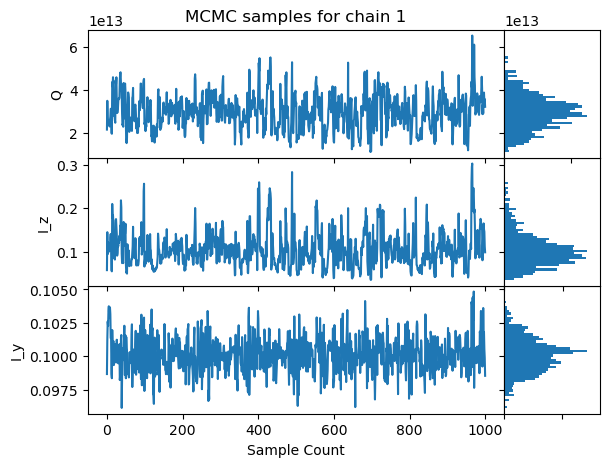

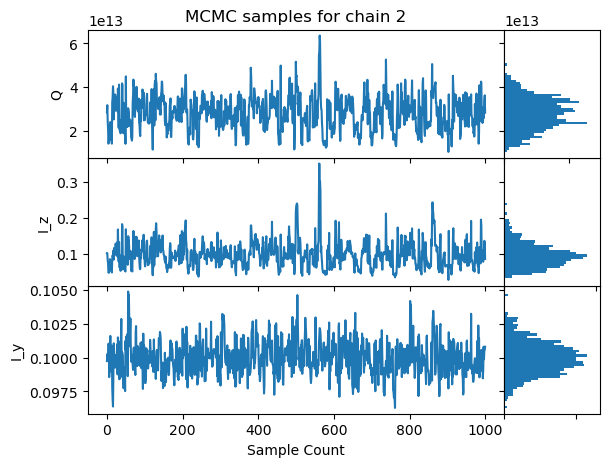

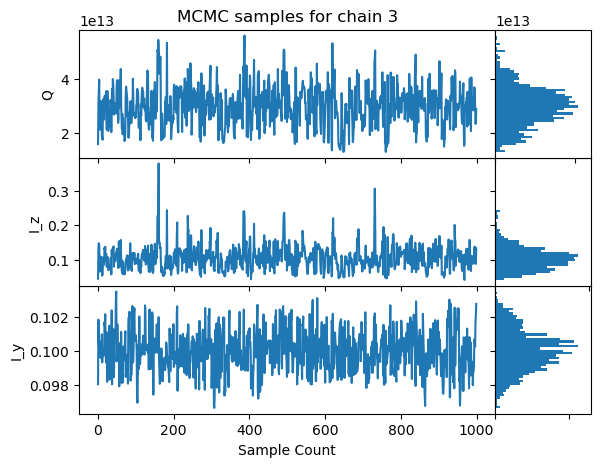

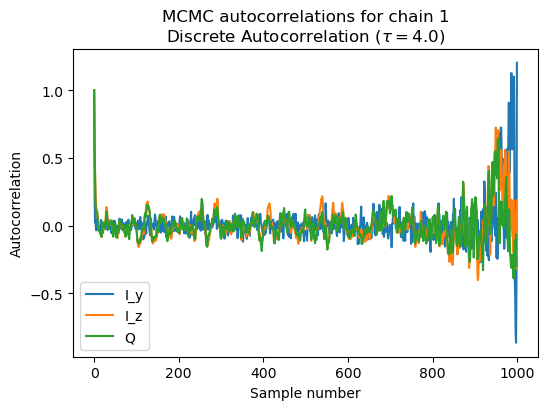

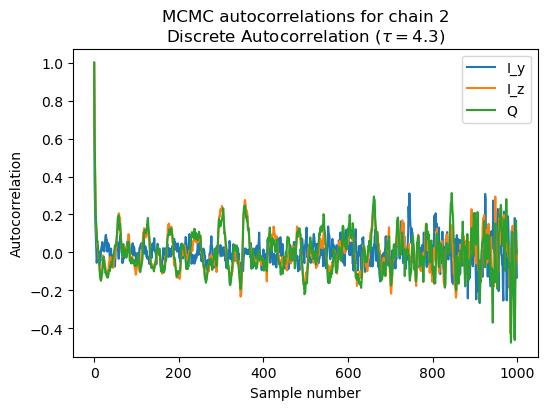

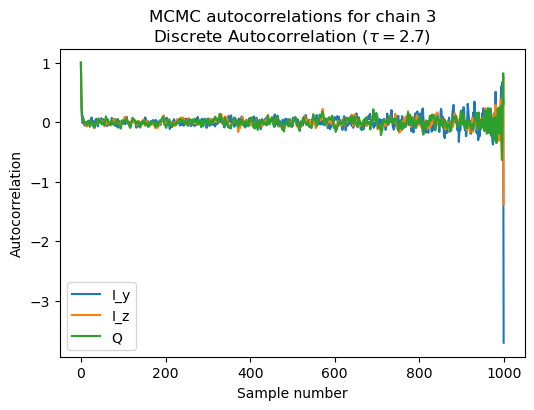

In [ ]:
visualiser = Visualiser(testing_data, params_samples, model, hyperparams, chain_samples=chain_samples, previous_instance = sampler.instance, data_path = 'results/inference')
visualiser.get_summary()
# visualiser.get_traceplot()
# visualiser.get_autocorrelations()

# domain = Domain('cone_from_source_z_limited', resolution=80)
# domain.add_domain_param('r', 100)
# domain.add_domain_param('theta', np.pi/8)
# domain.add_domain_param('source', [0,0,10])

# visualiser.visualise_results(domain = domain, name = 'small_scale_3D_plots', title='Log Concentration of Droplets', log_results=False)
# visualiser.animate(name = 'small_scale_3D_plots')